# Economic Data Analysis using Fred API and Pandas

# Initial setup

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt. rcParams["axes.prop_cycle"].by_key()["color"]

# Fred API Setup 
from fredapi import Fred
import configparser
# Read hidden key
config = configparser.ConfigParser()
config.read('config.ini')

fred_key = config['credentials']['api_key']

# 1. Create Fred object

In [14]:
fred = Fred(api_key = fred_key)

# 2. Search Economic Data

In [15]:
sp_search = fred.search('S&P', order_by = 'popularity') # sort data

In [16]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2024-04-02,2024-04-02,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2024-04-01,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-04-02 09:10:07-05:00,92,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2024-04-02,2024-04-02,S&P CoreLogic Case-Shiller U.S. National Home ...,1987-01-01,2024-01-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2024-03-26 08:11:02-05:00,88,"For more information regarding the index, plea..."
SP500,SP500,2024-04-02,2024-04-02,S&P 500,2014-04-02,2024-04-01,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2024-04-01 19:11:05-05:00,83,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2024-04-02,2024-04-02,Real Median Household Income in the United States,1984-01-01,2022-01-01,Annual,A,2022 CPI-U-RS Adjusted Dollars,2022 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2023-09-12 13:48:02-05:00,83,Household data are collected as of March. As ...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2024-04-02,2024-04-02,ICE BofA US High Yield Index Effective Yield,1996-12-31,2024-04-01,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-04-02 09:10:10-05:00,82,This data represents the effective yield of th...


# 3. Pull Raw Data & Plot

<Axes: title={'center': 'S&P 500'}>

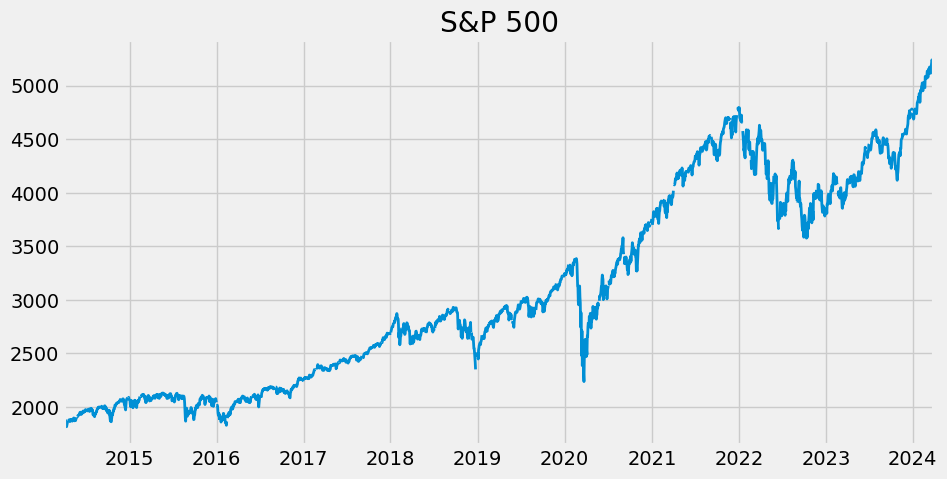

In [17]:
sp500 = fred.get_series(series_id = 'SP500') # separate data by series_id
sp500.plot(figsize = (10,5), title = 'S&P 500', lw = 2) # chart visualization 

# 4.Pull and Join Data Series

In [18]:
# Filter filters columns based on label or axis
unemp_df = fred.search('unemployment rate state', filter = ('frequency', 'Monthly'))
# Query filters rows based on boolean conditions
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
# separating by state using string filter on title
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate in')]

In [19]:
# Create list to store results
all_results = []
# Pull series data from each id
for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name = myid)
    all_results.append(results)
# Concatenate along column
uemp_states = pd.concat(all_results, axis =1).drop(['LASMT261982000000003', 'LASMT391746000000003'], axis = 1)

In [20]:
# Deleting missing values
uemp_states = uemp_states.dropna()

# Create dict to match state id´s to state names
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
# Replace state codes with state names using the id_to_state dictionary
uemp_states.columns = [id_to_state[col] for col in uemp_states.columns]


In [21]:
# Plot using plotly.express
px.line(uemp_states)

## May 2020 Unemployment Rate Per State

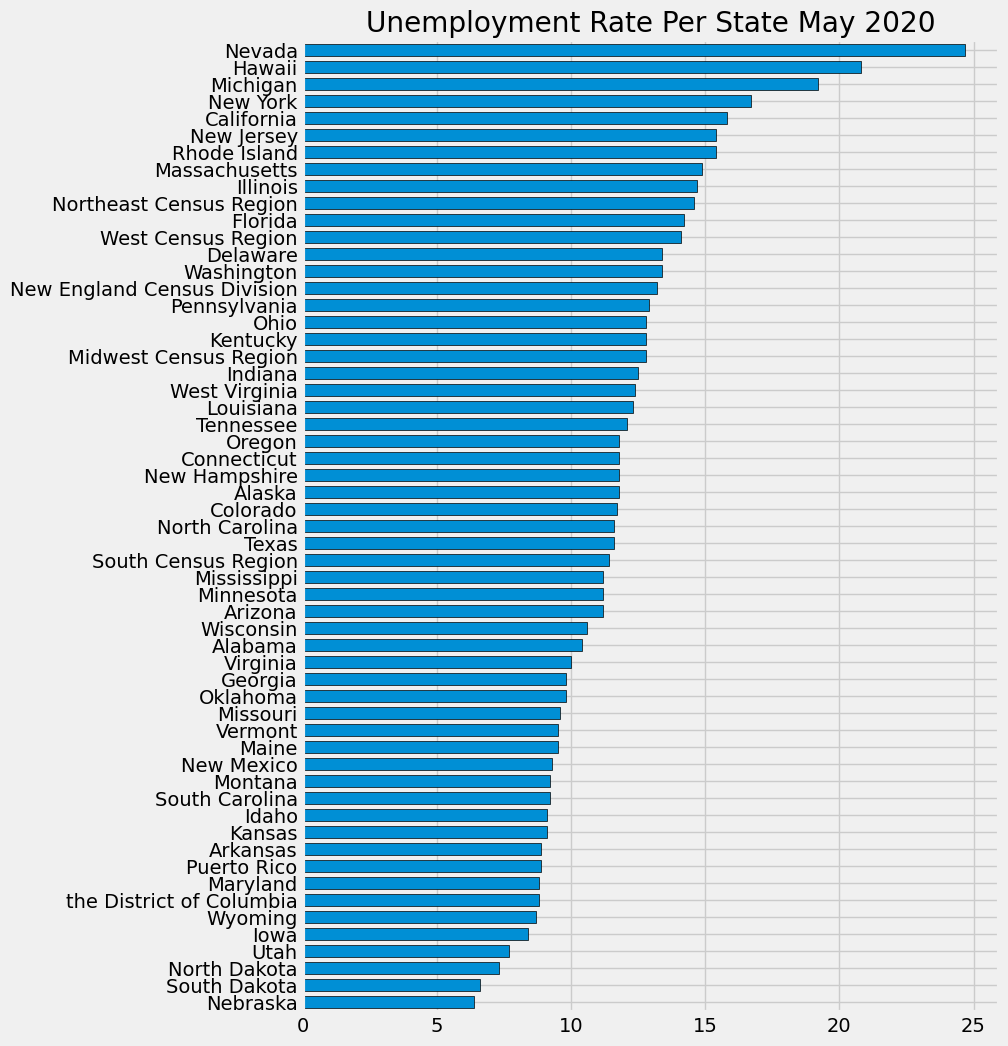

In [30]:
# Locate where our date ocurs                   # Transforms columns into rows
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T.sort_values('2020-05-01').plot(kind ='barh',
 figsize=(8, 12), width = 0.7, edgecolor = 'black',
 title='Unemployment Rate Per State May 2020')
ax.legend().remove()
plt.show()

# Pull participation Rate